In [1]:
import numpy as np   # numercal python. 수치 해석
import pandas as pd   # DataFrame을 쉽게 다루기

import matplotlib.pyplot as plt   # Data visualization
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.linewidth'] = 5
import seaborn as sns   # Data visualization
sns.set(font_scale = 2.0)   # seaborn 라이브러리 세팅 (plot의 모든 폰트 사이즈를 2.0로 지정)

from sklearn.model_selection import train_test_split
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

from datetime import datetime
import utils

import warnings
warnings.filterwarnings('ignore')   # ignore warning

In [2]:
dt = pd.read_csv('./03_oil_value_ts.csv')
dt.head(10)

,Code,Statistics,Fuel Type,Sulfur Content,Viscosity,Delivery Type,Location,Country,Continent,2022-01-04,...,2024-04-09,2024-04-10,2024-04-11,2024-04-12,2024-04-15,2024-04-16,2024-04-17,2024-04-18,2024-04-19,2024-04-22
0,PPXDK00,CLOSE,Fuel Oil,3.5%,380 CST,FOB,Singapore,Singapore,Asia,434.04,...,491.9,490.855,489.81,492.18,490.35,500.33,500.50,495.32,499.21,489.36
1,PUABC00,CLOSE,Fuel Oil,3.5%,Unknown,FOB,Rotterdam,Netherlands,Europe,430.50,...,474.0,466.750,472.50,479.00,472.00,485.00,482.75,477.00,472.75,467.50
2,PUAFT00,CLOSE,Bunker Fuel Oil,Unknown,380 CST,Delivered,Singapore,Singapore,Asia,447.00,...,507.0,506.000,505.00,507.00,505.00,507.00,512.00,509.00,513.00,507.00
3,AALMZ00,CLOSE,Marine Gasoil,0.5%,Unknown,Delivered,Singapore,Singapore,Asia,684.00,...,810.0,810.000,810.00,803.00,798.00,805.00,801.00,765.00,763.00,760.00
4,PUAFN00,CLOSE,Bunker Fuel Oil,3.5%,380 CST,Delivered,Rotterdam,Netherlands,Europe,439.00,...,475.0,468.000,472.00,496.00,474.00,486.00,483.00,477.00,476.00,469.00
5,AAYWT00,CLOSE,Gasoil,0.1%,Unknown,FOB,ARA Barge,Netherlands/Belgium,Europe,672.25,...,816.0,801.250,800.50,816.75,794.00,795.50,784.75,756.75,759.00,758.50
6,AARTG00,CLOSE,Marine Gasoil,0.1%,Unknown,Delivered,Rotterdam,Netherlands,Europe,670.00,...,805.0,797.000,800.00,805.00,790.00,790.00,780.00,760.00,750.00,750.00
7,AARKD00,CLOSE,Bunker Fuel Oil,Unknown,380 CST,Delivered,Shanghai,China,Asia,505.00,...,504.0,504.500,505.00,510.00,507.00,518.00,521.00,519.00,523.00,517.00
8,AARKE00,CLOSE,Marine Gasoil,0.5%,Unknown,Delivered,Shanghai,China,Asia,785.00,...,850.0,850.000,850.00,846.00,840.00,845.00,845.00,833.00,825.00,820.00
9,PUAFL00,CLOSE,Bunker Fuel Oil,3.5%,380 CST,Delivered,Piraeus,Greece,Europe,468.00,...,540.0,535.000,535.00,535.00,540.00,535.00,540.00,540.00,540.00,540.00


In [3]:
dt = dt[dt['Statistics'] == 'CLOSE'].drop(['Code', 'Country', 'Viscosity'], axis=1)

In [4]:
dt['Fuel Type'] = dt['Fuel Type'] + ' ' + (dt.groupby('Fuel Type').cumcount() + 1).astype(str)
dt

,Statistics,Fuel Type,Sulfur Content,Delivery Type,Location,Continent,2022-01-04,2022-01-05,2022-01-06,2022-01-07,...,2024-04-09,2024-04-10,2024-04-11,2024-04-12,2024-04-15,2024-04-16,2024-04-17,2024-04-18,2024-04-19,2024-04-22
0,CLOSE,Fuel Oil 1,3.5%,FOB,Singapore,Asia,434.04,436.28,438.37,450.78,...,491.90,490.855,489.81,492.18,490.35,500.33,500.50,495.32,499.21,489.36
1,CLOSE,Fuel Oil 2,3.5%,FOB,Rotterdam,Europe,430.50,437.75,444.00,442.00,...,474.00,466.750,472.50,479.00,472.00,485.00,482.75,477.00,472.75,467.50
2,CLOSE,Bunker Fuel Oil 1,Unknown,Delivered,Singapore,Asia,447.00,449.00,451.00,463.00,...,507.00,506.000,505.00,507.00,505.00,507.00,512.00,509.00,513.00,507.00
3,CLOSE,Marine Gasoil 1,0.5%,Delivered,Singapore,Asia,684.00,694.00,698.00,709.00,...,810.00,810.000,810.00,803.00,798.00,805.00,801.00,765.00,763.00,760.00
4,CLOSE,Bunker Fuel Oil 2,3.5%,Delivered,Rotterdam,Europe,439.00,445.00,456.00,456.00,...,475.00,468.000,472.00,496.00,474.00,486.00,483.00,477.00,476.00,469.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,CLOSE,Fuel Oil 5,3.5%,CIF,Med Cargo,Europe,436.00,442.00,449.75,446.75,...,493.50,491.250,498.25,505.50,498.50,506.00,501.75,496.00,492.00,487.75
89,CLOSE,Gasoil 6,0.1%,CIF,Med Cargo,Europe,690.50,706.75,715.25,715.50,...,835.75,831.000,830.50,846.00,822.25,821.75,810.75,779.00,781.00,783.00
92,CLOSE,Gasoil 7,0.1%,CIF,NWE Cargo,Europe,NaN,NaN,NaN,NaN,...,821.25,813.250,813.00,829.00,806.25,808.00,797.50,770.50,773.00,772.25
94,CLOSE,Marine Fuel 3,0.5%,Delivered,Santos,South America,NaN,NaN,NaN,NaN,...,676.00,677.000,670.00,672.00,668.00,670.00,664.00,659.00,661.00,649.00


In [5]:
date_columns = dt.columns[6:]
date_columns

Index(['2022-01-04', '2022-01-05', '2022-01-06', '2022-01-07', '2022-01-10',
       '2022-01-11', '2022-01-12', '2022-01-13', '2022-01-14', '2022-01-17',
       ...
       '2024-04-09', '2024-04-10', '2024-04-11', '2024-04-12', '2024-04-15',
       '2024-04-16', '2024-04-17', '2024-04-18', '2024-04-19', '2024-04-22'],
      dtype='object', length=595)

In [6]:
dt_fuel = dt.loc[:, date_columns].T
dt_fuel.columns = dt['Fuel Type']
dt_fuel.index = pd.to_datetime(dt_fuel.index)
dt_fuel

Fuel Type,Fuel Oil 1,Fuel Oil 2,Bunker Fuel Oil 1,Marine Gasoil 1,Bunker Fuel Oil 2,Gasoil 1,Marine Gasoil 2,Bunker Fuel Oil 3,Marine Gasoil 3,Bunker Fuel Oil 4,...,Marine Fuel 2,Bunker Fuel Oil 28,Marine Gasoil 36,Fuel Oil 4,Gasoil 5,Fuel Oil 5,Gasoil 6,Gasoil 7,Marine Fuel 3,Marine Gasoil 37
2022-01-04,434.04,430.50,447.0,684.0,439.0,672.25,670.0,505.0,785.0,468.0,...,569.00,493.0,715.0,427.50,673.75,436.00,690.50,NaN,NaN,NaN
2022-01-05,436.28,437.75,449.0,694.0,445.0,692.25,685.0,508.0,785.0,470.0,...,576.00,495.0,720.0,433.75,690.75,442.00,706.75,NaN,NaN,NaN
2022-01-06,438.37,444.00,451.0,698.0,456.0,701.25,703.0,510.0,785.0,473.0,...,581.50,501.0,730.0,441.50,699.25,449.75,715.25,NaN,NaN,NaN
2022-01-07,450.78,442.00,463.0,709.0,456.0,702.25,700.0,520.0,797.0,475.0,...,581.50,502.0,740.0,438.00,700.25,446.75,715.50,NaN,NaN,NaN
2022-01-10,448.57,437.25,461.0,712.0,451.0,698.75,702.0,515.0,790.0,479.0,...,582.50,505.0,740.0,433.00,698.50,441.75,713.25,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16,500.33,485.00,507.0,805.0,486.0,795.50,790.0,518.0,845.0,535.0,...,622.25,583.0,853.0,494.00,802.50,506.00,821.75,808.00,670.0,904.0
2024-04-17,500.50,482.75,512.0,801.0,483.0,784.75,780.0,521.0,845.0,540.0,...,614.75,577.0,850.0,489.75,789.25,501.75,810.75,797.50,664.0,900.0
2024-04-18,495.32,477.00,509.0,765.0,477.0,756.75,760.0,519.0,833.0,540.0,...,602.25,570.0,830.0,484.00,758.00,496.00,779.00,770.50,659.0,896.0
2024-04-19,499.21,472.75,513.0,763.0,476.0,759.00,750.0,523.0,825.0,540.0,...,602.00,570.0,825.0,480.00,761.00,492.00,781.00,773.00,661.0,899.0


In [7]:
# 결측치 컬럼 삭제
dt_fuel = dt_fuel.iloc[:, :-3]
dt_fuel

Fuel Type,Fuel Oil 1,Fuel Oil 2,Bunker Fuel Oil 1,Marine Gasoil 1,Bunker Fuel Oil 2,Gasoil 1,Marine Gasoil 2,Bunker Fuel Oil 3,Marine Gasoil 3,Bunker Fuel Oil 4,...,Marine Gasoil 34,Marine Gasoil 35,Marine Fuel 1,Marine Fuel 2,Bunker Fuel Oil 28,Marine Gasoil 36,Fuel Oil 4,Gasoil 5,Fuel Oil 5,Gasoil 6
2022-01-04,434.04,430.50,447.0,684.0,439.0,672.25,670.0,505.0,785.0,468.0,...,699.0,705.0,561.50,569.00,493.0,715.0,427.50,673.75,436.00,690.50
2022-01-05,436.28,437.75,449.0,694.0,445.0,692.25,685.0,508.0,785.0,470.0,...,715.0,705.0,568.50,576.00,495.0,720.0,433.75,690.75,442.00,706.75
2022-01-06,438.37,444.00,451.0,698.0,456.0,701.25,703.0,510.0,785.0,473.0,...,734.0,705.0,574.00,581.50,501.0,730.0,441.50,699.25,449.75,715.25
2022-01-07,450.78,442.00,463.0,709.0,456.0,702.25,700.0,520.0,797.0,475.0,...,725.0,705.0,573.75,581.50,502.0,740.0,438.00,700.25,446.75,715.50
2022-01-10,448.57,437.25,461.0,712.0,451.0,698.75,702.0,515.0,790.0,479.0,...,735.0,710.0,574.75,582.50,505.0,740.0,433.00,698.50,441.75,713.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16,500.33,485.00,507.0,805.0,486.0,795.50,790.0,518.0,845.0,535.0,...,860.0,717.0,611.50,622.25,583.0,853.0,494.00,802.50,506.00,821.75
2024-04-17,500.50,482.75,512.0,801.0,483.0,784.75,780.0,521.0,845.0,540.0,...,850.0,717.0,604.00,614.75,577.0,850.0,489.75,789.25,501.75,810.75
2024-04-18,495.32,477.00,509.0,765.0,477.0,756.75,760.0,519.0,833.0,540.0,...,835.0,716.0,591.50,602.25,570.0,830.0,484.00,758.00,496.00,779.00
2024-04-19,499.21,472.75,513.0,763.0,476.0,759.00,750.0,523.0,825.0,540.0,...,855.0,717.0,591.25,602.00,570.0,825.0,480.00,761.00,492.00,781.00


In [8]:
dt_fuel_mg = dt_fuel.filter(regex='Marine Gasoil')
dt_fuel_mg

Fuel Type,Marine Gasoil 1,Marine Gasoil 2,Marine Gasoil 3,Marine Gasoil 4,Marine Gasoil 5,Marine Gasoil 6,Marine Gasoil 7,Marine Gasoil 8,Marine Gasoil 9,Marine Gasoil 10,...,Marine Gasoil 27,Marine Gasoil 28,Marine Gasoil 29,Marine Gasoil 30,Marine Gasoil 31,Marine Gasoil 32,Marine Gasoil 33,Marine Gasoil 34,Marine Gasoil 35,Marine Gasoil 36
2022-01-04,684.0,670.0,785.0,701.0,700.0,735.0,708.25,777.0,775.5,757.0,...,797.0,809.0,754.0,713.0,670.0,775.0,702.0,699.0,705.0,715.0
2022-01-05,694.0,685.0,785.0,710.0,705.0,755.0,722.25,778.0,800.5,782.0,...,822.0,834.0,762.0,727.0,685.0,770.0,715.0,715.0,705.0,720.0
2022-01-06,698.0,703.0,785.0,711.0,709.0,760.0,715.00,785.0,802.5,784.0,...,824.0,836.0,773.0,747.0,703.0,770.0,733.0,734.0,705.0,730.0
2022-01-07,709.0,700.0,797.0,720.0,715.0,770.0,733.00,786.0,806.5,788.0,...,828.0,840.0,768.0,749.0,700.0,780.0,727.0,725.0,705.0,740.0
2022-01-10,712.0,702.0,790.0,720.0,718.0,795.0,736.00,792.0,813.5,795.0,...,835.0,847.0,775.0,750.0,702.0,785.0,725.0,735.0,710.0,740.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16,805.0,790.0,845.0,880.0,808.0,900.0,816.50,911.0,876.5,858.0,...,869.0,881.0,900.0,865.0,790.0,890.0,870.0,860.0,717.0,853.0
2024-04-17,801.0,780.0,845.0,875.0,808.0,900.0,814.50,893.0,865.5,847.0,...,858.0,870.0,890.0,860.0,780.0,894.0,870.0,850.0,717.0,850.0
2024-04-18,765.0,760.0,833.0,865.0,782.0,890.0,799.50,883.0,859.5,841.0,...,852.0,864.0,880.0,850.0,760.0,885.0,840.0,835.0,716.0,830.0
2024-04-19,763.0,750.0,825.0,855.0,772.0,875.0,792.50,884.0,860.5,842.0,...,853.0,865.0,878.0,840.0,750.0,880.0,830.0,855.0,717.0,825.0


어제와 동일하게 Marine Gasoil 9 데이터를 사용합니다.

In [9]:
ts = dt_fuel_mg['Marine Gasoil 9']
ts

2022-01-04    775.5
2022-01-05    800.5
2022-01-06    802.5
2022-01-07    806.5
2022-01-10    813.5
              ...  
2024-04-16    876.5
2024-04-17    865.5
2024-04-18    859.5
2024-04-19    860.5
2024-04-22    861.5
Name: Marine Gasoil 9, Length: 595, dtype: float64

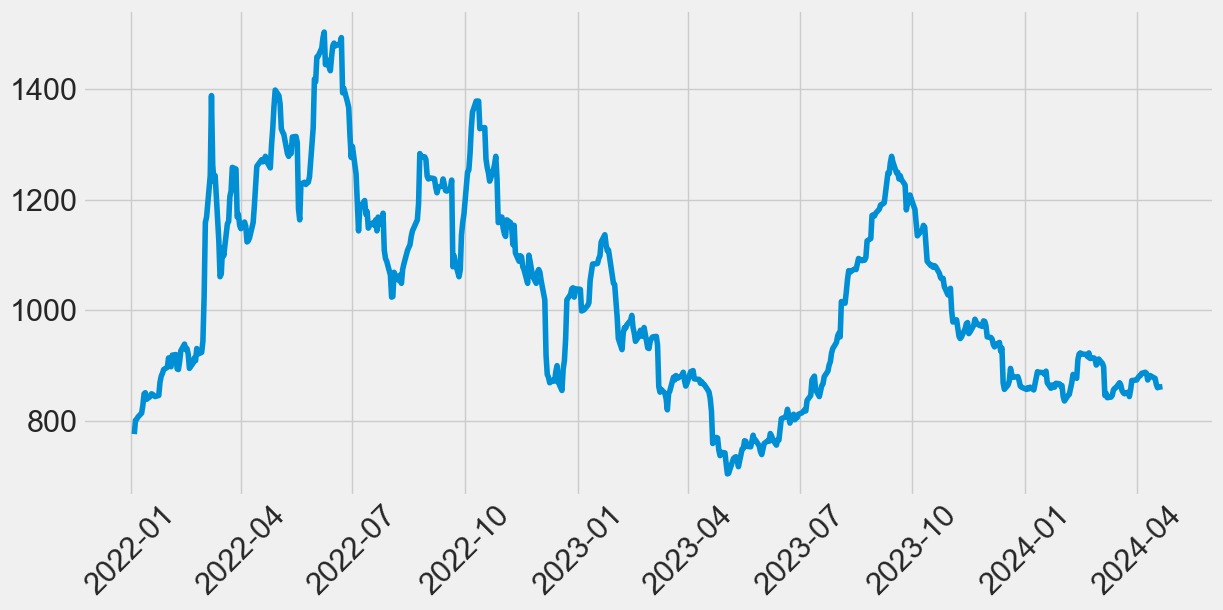

In [10]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6
plt.xticks(rotation=45)
plt.plot(ts);

In [11]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts, period=30)

trend = decomposition.trend # 추세(시간 추이에 따라 나타나는 평균값 변화 )
seasonal = decomposition.seasonal # 계절성(패턴이 파악되지 않은 주기적 변화)
residual = decomposition.resid # 원본(로그변환한) - 추세 - 계절성

In [13]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                  -2.154450
p-value                          0.223191
#Lags Used                       5.000000
Number of Observations Used    589.000000
Critical Value (1%)             -3.441501
Critical Value (5%)             -2.866460
Critical Value (10%)            -2.569390
dtype: float64


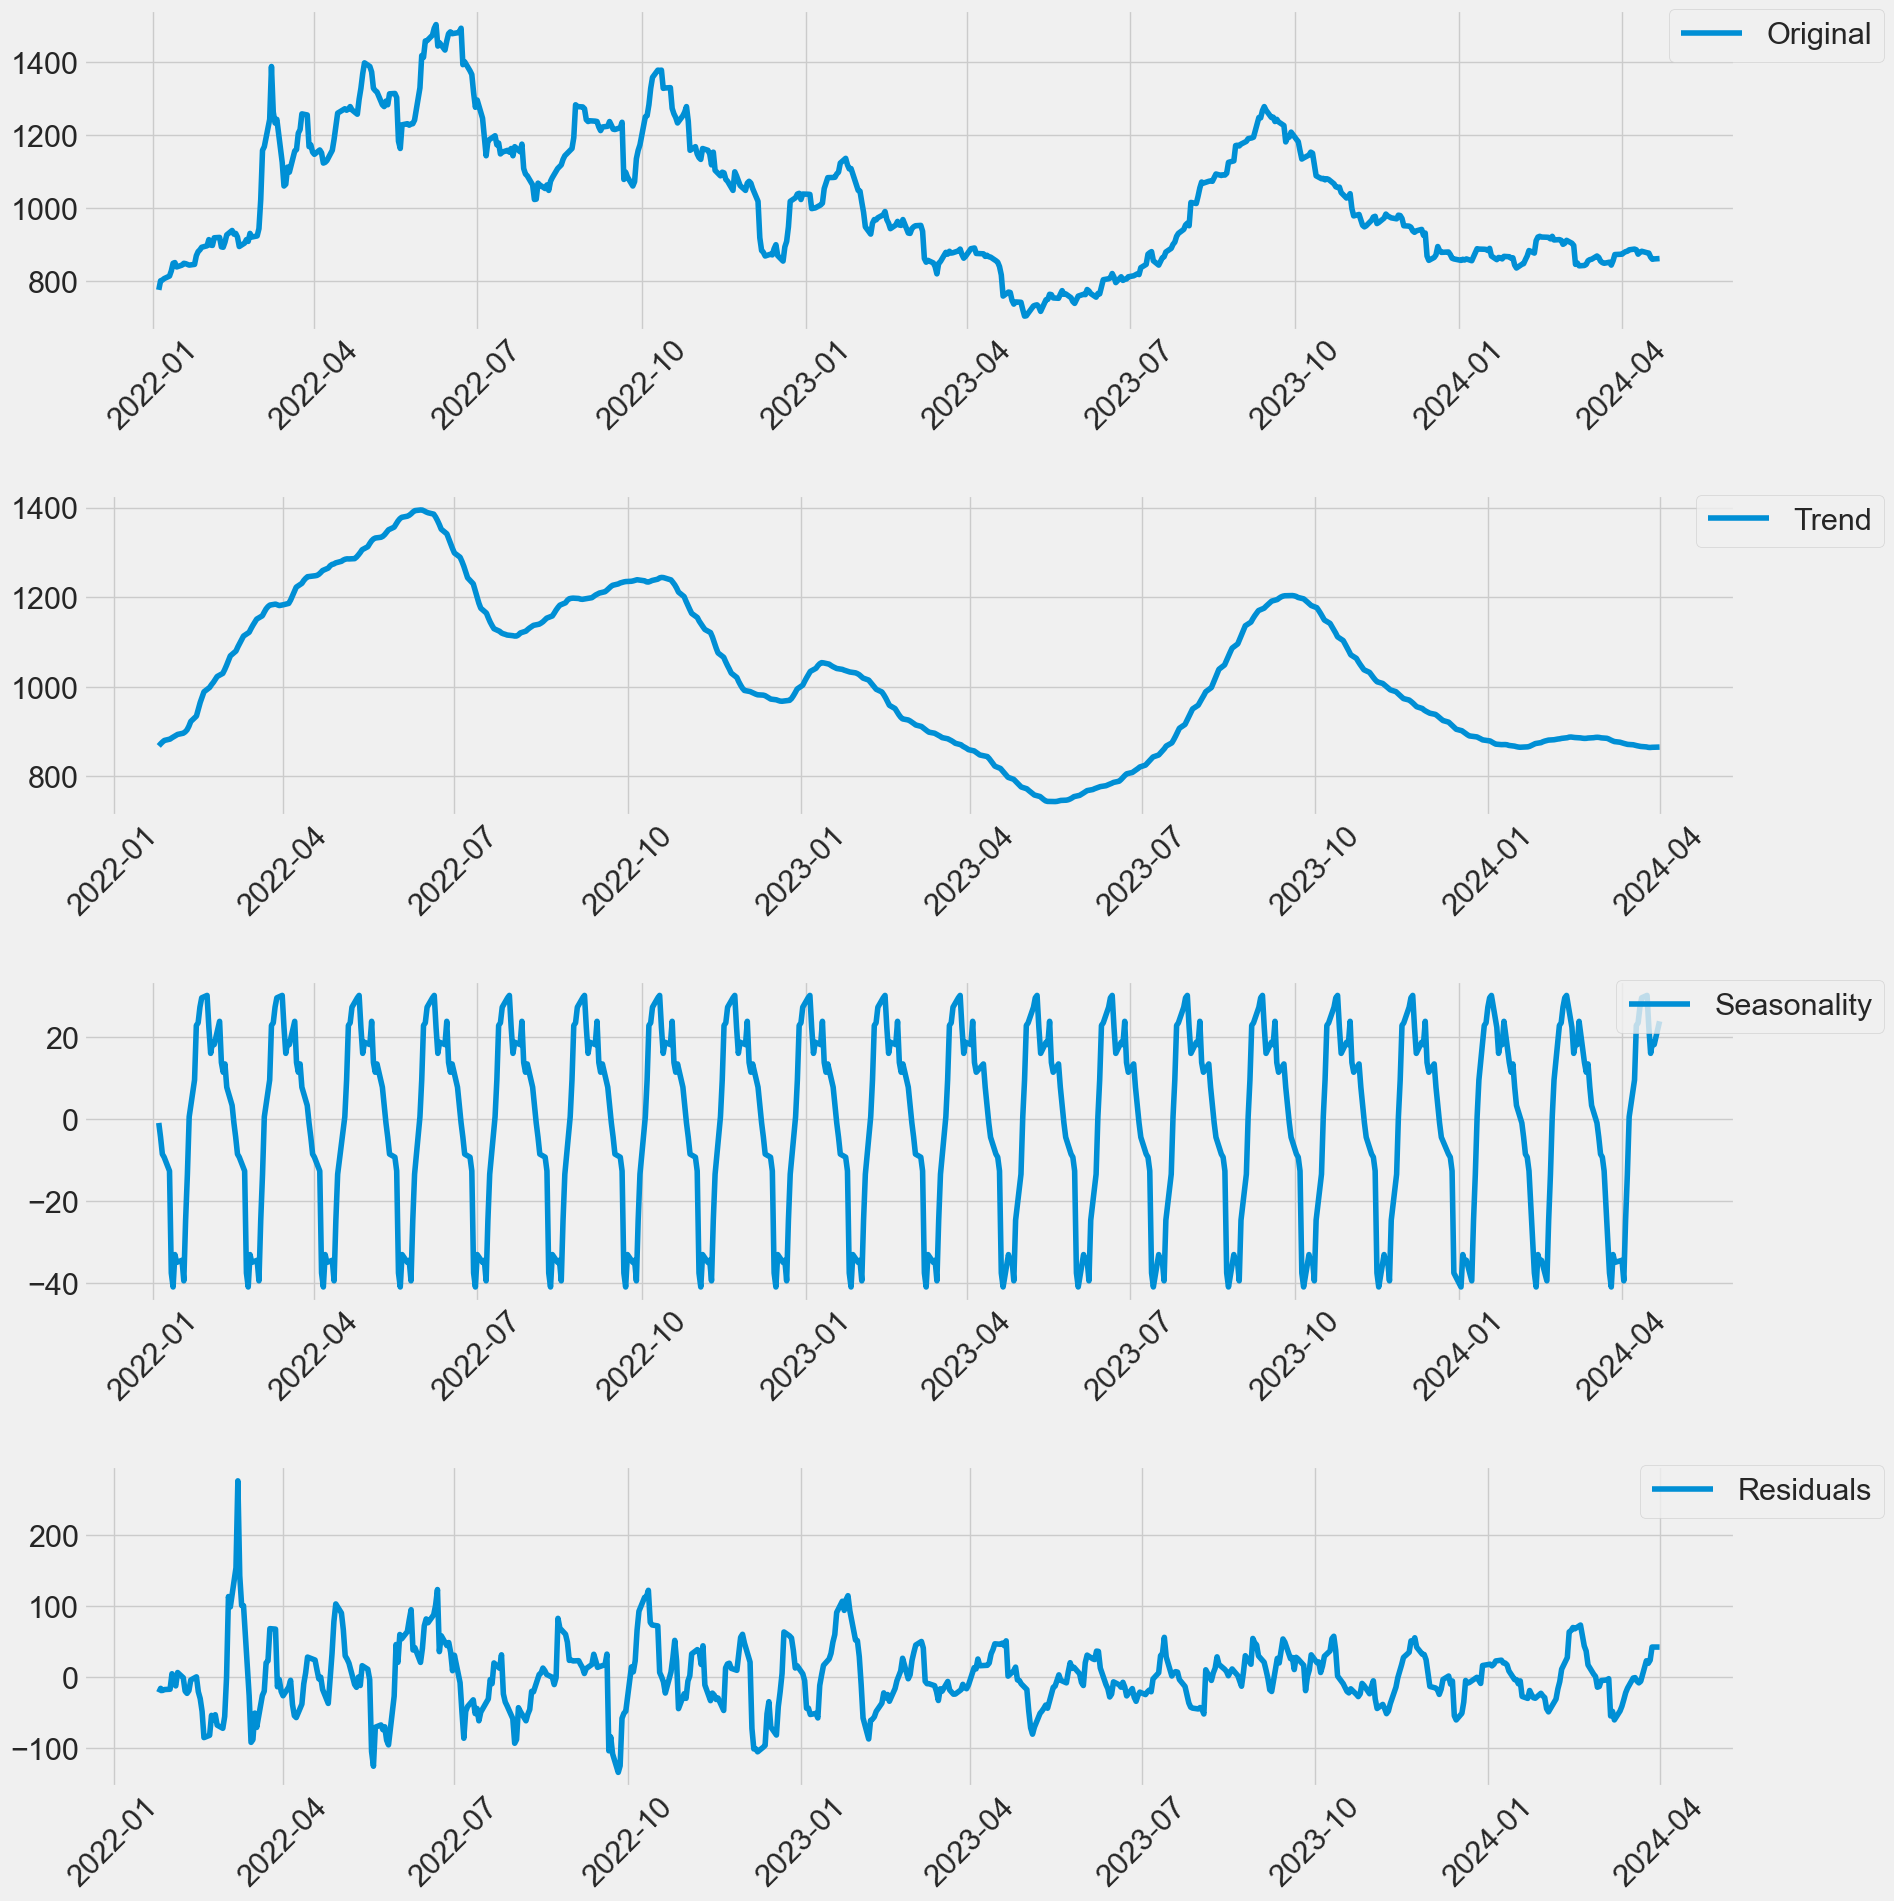

In [14]:
plt.rcParams["figure.figsize"] = (20, 20)
plt.subplot(411)
plt.plot(ts, label='Original')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(413)
plt.plot(seasonal, label='Seasonality')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.05))
plt.xticks(rotation=45)
plt.grid(True)

plt.tight_layout(pad=3.0)
plt.show()

- __trend__: 2022년 중반까지 상승, 그 이후 점진적 하락, 2023년 말부터 다시 상승  
- __seasonality__: 매우 규칙적이고 주기적인 계절성 패턴.
- __residuals__: 대부분은 안정 범위 내에서 변동. 몇몇 큰 peak, valley를 제외하고는 크게 돌출된 부분이 없음.

In [15]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -7.545854e+00
p-value                        3.285164e-11
#Lags Used                     1.700000e+01
Number of Observations Used    5.470000e+02
Critical Value (1%)           -3.442361e+00
Critical Value (5%)           -2.866838e+00
Critical Value (10%)          -2.569592e+00
dtype: float64


잔차에 대한 시계열 데이터의 p-value는 0에 매우 가까우므로, 시계열은 비정상적이라는 귀무가설을 반박한다.  
즉, residual 시계열 데이터는 정상성을 가지고 있다.

참고 자료: [월간 데이콘 주식 종료 가격 예측](https://dacon.io/codeshare/3399)  

종목별로 전처리한 부분은 다음과 같습니다.  
1. 시계열 분해를 통해 종가 추세와 계절성 데이터를 추가  
2. 종가에 대하여 5일, 20일, 60일, 120일, 240일 이동평균을 추가  
3. 최종적으로 일주일씩 (business day 기준으로 5일씩) lag features를 생성 (종가 컬럼은 train 데이터와 validation 데이터에서 y값으로 사용하기 위하여 lag 하지 않았고 test 데이터에서는 불필요하기 때문에 drop)  

모델링 시 알고리즘은 XGBoost를 사용하였습니다. validation 데이터는 예측 기간의 일주일 전 데이터로 잡았습니다.  
감사합니다.

In [16]:
ts = pd.DataFrame(ts)
ts.index.name = 'Date'
ts.rename(columns={'Marine Gasoil 9': 'Marine Gasoil 9_Price'}, inplace=True)
ts

,Marine Gasoil 9_Price
Date,
2022-01-04,775.5
2022-01-05,800.5
2022-01-06,802.5
2022-01-07,806.5
2022-01-10,813.5
...,...
2024-04-16,876.5
2024-04-17,865.5
2024-04-18,859.5


In [17]:
ts['trend'] = trend.fillna(method='ffill').fillna(method = 'bfill')  # 앞의 값으로 채우기
ts['seasonal'] = seasonal
ts.head(20)

,Marine Gasoil 9_Price,trend,seasonal
Date,,,
2022-01-04,775.5,868.116667,-0.874786
2022-01-05,800.5,868.116667,-4.356365
2022-01-06,802.5,868.116667,-8.475663
2022-01-07,806.5,868.116667,-9.223031
2022-01-10,813.5,868.116667,-12.591452
2022-01-11,827.5,868.116667,-37.463382
2022-01-12,848.5,868.116667,-40.875663
2022-01-13,850.5,868.116667,-32.971277
2022-01-14,838.5,868.116667,-34.887066


In [18]:
ts.tail(20)

,Marine Gasoil 9_Price,trend,seasonal
Date,,,
2024-03-25,851.5,865.916667,-37.463382
2024-03-26,843.5,864.933333,-40.875663
2024-03-27,855.5,864.633333,-32.971277
2024-03-28,872.5,865.050000,-34.887066
2024-04-01,873.5,865.566667,-34.364259
2024-04-02,877.5,865.566667,-39.376296
2024-04-03,880.5,865.566667,-24.572593
2024-04-04,881.5,865.566667,-13.380000
2024-04-05,885.5,865.566667,0.619074


__이동 평균 (Moving Averages)__  
이동 평균은 시계열 데이터에서 단기적인 노이즈를 제거하고, 장기적인 추세를 보다 명확하게 파악하는 데 도움을 줍니다. 이를 통해 데이터의 변동성을 줄이고, 추세에 대한 더 깨끗하고 일관된 신호를 얻을 수 있습니다. 

In [19]:
# 이동평균을 추가하는 함수
def add_rolling_mean(df:pd.DataFrame, col_name:str, window_list:list)->pd.DataFrame:
    for window in window_list:
        df[col_name + f'_rollling{window}'] = df[col_name].rolling(window).mean().fillna(method='bfill')
    return df

In [20]:
# 5일(1주), 10일(2주), 20일(1개월), 60일(3개월), 120일(6개월), 240일(1년) 이동평균 추가 
ts = add_rolling_mean(ts, 'Marine Gasoil 9_Price', [5, 10, 20, 60, 120, 240])
ts.head(20)

,Marine Gasoil 9_Price,trend,seasonal,Marine Gasoil 9_Price_rollling5,Marine Gasoil 9_Price_rollling10,Marine Gasoil 9_Price_rollling20,Marine Gasoil 9_Price_rollling60,Marine Gasoil 9_Price_rollling120,Marine Gasoil 9_Price_rollling240
Date,,,,,,,,,
2022-01-04,775.5,868.116667,-0.874786,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-05,800.5,868.116667,-4.356365,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-06,802.5,868.116667,-8.475663,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-07,806.5,868.116667,-9.223031,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-10,813.5,868.116667,-12.591452,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-11,827.5,868.116667,-37.463382,810.1,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-12,848.5,868.116667,-40.875663,819.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-13,850.5,868.116667,-32.971277,829.3,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-14,838.5,868.116667,-34.887066,835.7,820.7,843.1,975.375,1141.545833,1160.53125


__Lag Features__  
Lag features는 과거 데이터의 값들을 현재의 예측에 사용함으로써 모델이 데이터의 시간적인 연속성을 인식하도록 돕습니다.  
특히 시계열 데이터에서 lag features는 자기상관성을 모델링하는 데 중요합니다.  
예를 들어, '일주일 전의 유가'와 같은 feature는 다음 주의 유가를 예측하는 데 매우 유용할 수 있습니다.

In [21]:
def lag_features(df:pd.DataFrame, col_list:list, lag_num:int)->pd.DataFrame:
    for col in col_list:
        df[col] = df[col].shift(lag_num).fillna(method='ffill').fillna(method='bfill')
    return df

In [22]:
col_list = list(ts.columns)
col_list.remove('Marine Gasoil 9_Price')
ts = lag_features(ts, col_list, 5)
ts.head(20)

,Marine Gasoil 9_Price,trend,seasonal,Marine Gasoil 9_Price_rollling5,Marine Gasoil 9_Price_rollling10,Marine Gasoil 9_Price_rollling20,Marine Gasoil 9_Price_rollling60,Marine Gasoil 9_Price_rollling120,Marine Gasoil 9_Price_rollling240
Date,,,,,,,,,
2022-01-04,775.5,868.116667,-0.874786,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-05,800.5,868.116667,-0.874786,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-06,802.5,868.116667,-0.874786,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-07,806.5,868.116667,-0.874786,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-10,813.5,868.116667,-0.874786,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-11,827.5,868.116667,-0.874786,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-12,848.5,868.116667,-4.356365,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-13,850.5,868.116667,-8.475663,799.7,820.7,843.1,975.375,1141.545833,1160.53125
2022-01-14,838.5,868.116667,-9.223031,799.7,820.7,843.1,975.375,1141.545833,1160.53125


In [23]:
ts['Year'] = ts.index.year
ts['Quarter'] = ts.index.quarter
ts['Month'] = ts.index.month
ts['Dayofweek'] = ts.index.dayofweek
ts['Dayofmonth'] = ts.index.day
ts['Weekofyear'] = ts.index.isocalendar().week
ts['Dayofyear'] = ts.index.dayofyear


In [24]:
ts['Index'] = ts.index
ts

,Marine Gasoil 9_Price,trend,seasonal,Marine Gasoil 9_Price_rollling5,Marine Gasoil 9_Price_rollling10,Marine Gasoil 9_Price_rollling20,Marine Gasoil 9_Price_rollling60,Marine Gasoil 9_Price_rollling120,Marine Gasoil 9_Price_rollling240,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear,Index
Date,,,,,,,,,,,,,,,,,
2022-01-04,775.5,868.116667,-0.874786,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,2022,1,1,1,4,1,4,2022-01-04
2022-01-05,800.5,868.116667,-0.874786,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,2022,1,1,2,5,1,5,2022-01-05
2022-01-06,802.5,868.116667,-0.874786,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,2022,1,1,3,6,1,6,2022-01-06
2022-01-07,806.5,868.116667,-0.874786,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,2022,1,1,4,7,1,7,2022-01-07
2022-01-10,813.5,868.116667,-0.874786,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,2022,1,1,0,10,2,10,2022-01-10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16,876.5,865.566667,22.905039,884.1,874.3,865.00,876.308333,909.875000,937.464583,2024,2,4,1,16,16,107,2024-04-16
2024-04-17,865.5,865.566667,23.530478,882.7,877.3,866.40,876.091667,908.166667,938.139583,2024,2,4,2,17,16,108,2024-04-17
2024-04-18,859.5,865.566667,27.349776,882.1,879.6,867.55,876.008333,906.600000,938.752083,2024,2,4,3,18,16,109,2024-04-18


## 머신러닝

In [25]:
last_date = ts.index.max()
last_date

Timestamp('2024-04-22 00:00:00')

In [26]:
test_start_date = last_date - pd.Timedelta(days=13)  # 주말 제외 열흘이 되도록 조정 (주말 제외 2주)
validation_start_date = test_start_date - pd.Timedelta(days=28)  # 주말 제외 20일이 되도록 조정 (주말 제외 한 달)

In [27]:
train = ts.loc[:validation_start_date]
validation = ts.loc[validation_start_date:test_start_date]
test = ts.loc[test_start_date:]

train.shape, validation.shape, test.shape

((567, 17), (20, 17), (10, 17))

In [28]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 567 entries, 2022-01-04 to 2024-03-12
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Marine Gasoil 9_Price              567 non-null    float64       
 1   trend                              567 non-null    float64       
 2   seasonal                           567 non-null    float64       
 3   Marine Gasoil 9_Price_rollling5    567 non-null    float64       
 4   Marine Gasoil 9_Price_rollling10   567 non-null    float64       
 5   Marine Gasoil 9_Price_rollling20   567 non-null    float64       
 6   Marine Gasoil 9_Price_rollling60   567 non-null    float64       
 7   Marine Gasoil 9_Price_rollling120  567 non-null    float64       
 8   Marine Gasoil 9_Price_rollling240  567 non-null    float64       
 9   Year                               567 non-null    int32         
 10  Quarter            

In [29]:
train['Weekofyear'] = train['Weekofyear'].astype('int32')
validation['Weekofyear'] = validation['Weekofyear'].astype('int32')
test['Weekofyear'] = test['Weekofyear'].astype('int32')

In [30]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 567 entries, 2022-01-04 to 2024-03-12
Data columns (total 17 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   Marine Gasoil 9_Price              567 non-null    float64       
 1   trend                              567 non-null    float64       
 2   seasonal                           567 non-null    float64       
 3   Marine Gasoil 9_Price_rollling5    567 non-null    float64       
 4   Marine Gasoil 9_Price_rollling10   567 non-null    float64       
 5   Marine Gasoil 9_Price_rollling20   567 non-null    float64       
 6   Marine Gasoil 9_Price_rollling60   567 non-null    float64       
 7   Marine Gasoil 9_Price_rollling120  567 non-null    float64       
 8   Marine Gasoil 9_Price_rollling240  567 non-null    float64       
 9   Year                               567 non-null    int32         
 10  Quarter            

In [31]:
time_series_target = 'Marine Gasoil 9_Price'

# rag feature를 5로 설정했으므로 [:-5]를 사용
X_train = train[:-5].drop(columns=['Marine Gasoil 9_Price', 'Index'])
y_train = train[:-5][time_series_target]

X_val = validation[:-5].drop(columns=['Marine Gasoil 9_Price', 'Index'])
y_val = validation[:-5][time_series_target]

X_test = test.drop(columns=['Marine Gasoil 9_Price', 'Index'])
y_test = test[time_series_target]

In [32]:
xgb_model = XGBRegressor(base_score=0.5, booster='gbtree',
                         n_estimators=10000,
                         early_stopping_rounds=50,
                         objective='reg:linear',
                         max_depth=6,
                         learning_rate=0.01,
                         min_child_weight=1,
                         subsample=0.8,
                         colsample_bytree=0.8,
                         gamma=0,
                         reg_alpha=0,
                         reg_lambda=1)

xgb_model.fit(X_train, y_train, 
                  eval_set = [(X_val, y_val)],
                  verbose=100)

[0]	validation_0-rmse:849.05541
[100]	validation_0-rmse:300.52396
[200]	validation_0-rmse:99.71647
[300]	validation_0-rmse:27.05196
[400]	validation_0-rmse:18.06683
[430]	validation_0-rmse:19.14511


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [33]:
pred_val = xgb_model.predict(X_val)
pred_test = xgb_model.predict(X_test)

pred_val_df = pd.DataFrame(pred_val, index=X_val.index, columns=['prediction_xgb_val'])
pred_test_df = pd.DataFrame(pred_test, index=X_test.index, columns=['prediction_xgb'])

ts = ts.merge(pred_val_df, how='left', left_index=True, right_index=True)
ts = ts.merge(pred_test_df, how='left', left_index=True, right_index=True)
ts

,Marine Gasoil 9_Price,trend,seasonal,Marine Gasoil 9_Price_rollling5,Marine Gasoil 9_Price_rollling10,Marine Gasoil 9_Price_rollling20,Marine Gasoil 9_Price_rollling60,Marine Gasoil 9_Price_rollling120,Marine Gasoil 9_Price_rollling240,Year,Quarter,Month,Dayofweek,Dayofmonth,Weekofyear,Dayofyear,Index,prediction_xgb_val,prediction_xgb
Date,,,,,,,,,,,,,,,,,,,
2022-01-04,775.5,868.116667,-0.874786,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,2022,1,1,1,4,1,4,2022-01-04,NaN,NaN
2022-01-05,800.5,868.116667,-0.874786,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,2022,1,1,2,5,1,5,2022-01-05,NaN,NaN
2022-01-06,802.5,868.116667,-0.874786,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,2022,1,1,3,6,1,6,2022-01-06,NaN,NaN
2022-01-07,806.5,868.116667,-0.874786,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,2022,1,1,4,7,1,7,2022-01-07,NaN,NaN
2022-01-10,813.5,868.116667,-0.874786,799.7,820.7,843.10,975.375000,1141.545833,1160.531250,2022,1,1,0,10,2,10,2022-01-10,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-16,876.5,865.566667,22.905039,884.1,874.3,865.00,876.308333,909.875000,937.464583,2024,2,4,1,16,16,107,2024-04-16,NaN,862.958130
2024-04-17,865.5,865.566667,23.530478,882.7,877.3,866.40,876.091667,908.166667,938.139583,2024,2,4,2,17,16,108,2024-04-17,NaN,862.923218
2024-04-18,859.5,865.566667,27.349776,882.1,879.6,867.55,876.008333,906.600000,938.752083,2024,2,4,3,18,16,109,2024-04-18,NaN,862.319885


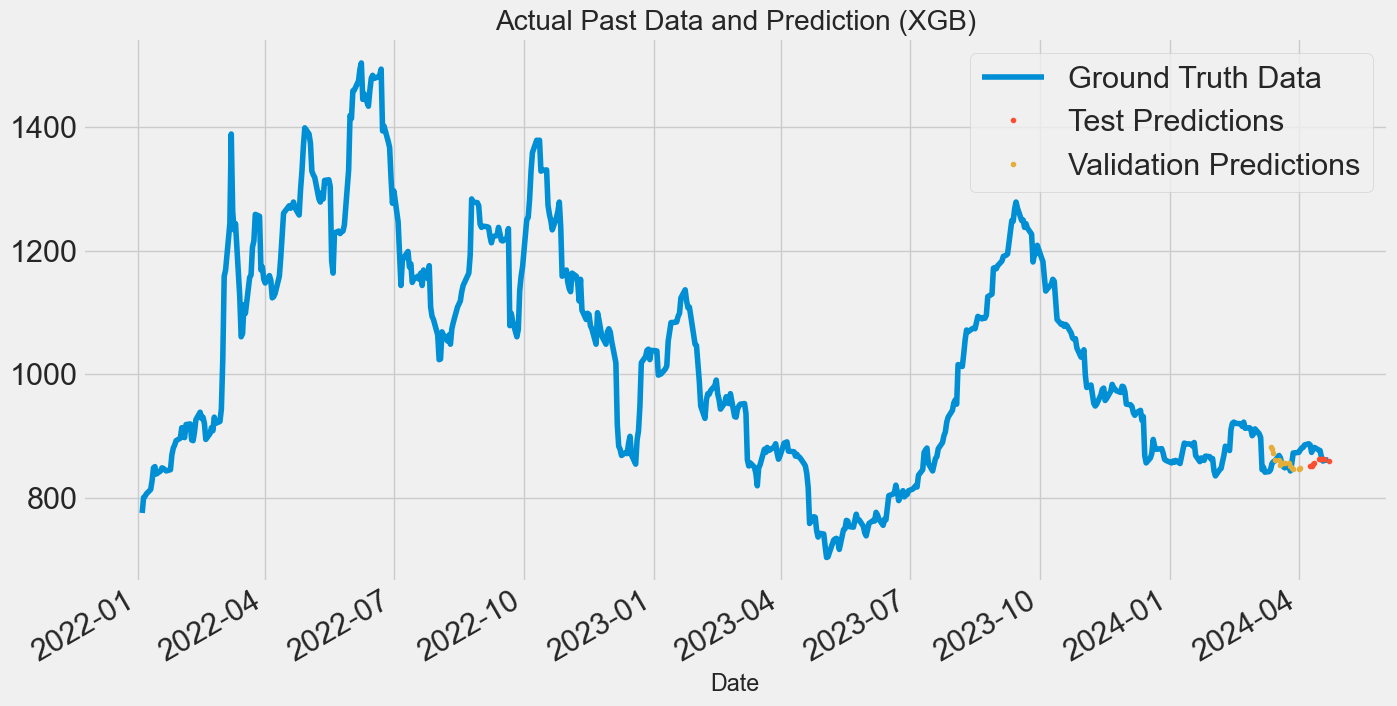

In [34]:
ax = ts['Marine Gasoil 9_Price'].plot(figsize=(15,8))
ts['prediction_xgb'].plot(ax=ax, style='.')
ts['prediction_xgb_val'].plot(ax=ax, style='.')
plt.legend(['Ground Truth Data', 'Test Predictions', 'Validation Predictions'])
ax.set_title('Actual Past Data and Prediction (XGB)')
plt.show();

In [35]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

ts_clean = ts.dropna(subset=['prediction_xgb_val', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb_val = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val'])
score_rmse_xgb_val = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val']))
score_mape_xgb_val = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb_val'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb_val:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb_val:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb_val:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 14.11
RMSE Score on Validation set (XGB): 17.65
MAPE Score on Validation set (XGB): 1.64%


In [36]:
ts_clean = ts.dropna(subset=['prediction_xgb', 'Marine Gasoil 9_Price'])

# RMSE 및 R^2 점수 계산
score_mae_xgb = mean_absolute_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb'])
score_rmse_xgb = np.sqrt(mean_squared_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb']))
score_mape_xgb = mean_absolute_percentage_error(ts_clean['Marine Gasoil 9_Price'], ts_clean['prediction_xgb'])

# 결과 출력
print(f'MAE Score on Validation set (XGB): {score_mae_xgb:0.2f}')
print(f'RMSE Score on Validation set (XGB): {score_rmse_xgb:0.2f}')
print(f'MAPE Score on Validation set (XGB): {score_mape_xgb:.2%}')  # 백분율 형식으로 출력

MAE Score on Validation set (XGB): 14.22
RMSE Score on Validation set (XGB): 18.05
MAPE Score on Validation set (XGB): 1.62%


In [37]:
import shap

xgb_explainer = shap.Explainer(xgb_model)
shap_values_xgb = xgb_explainer.shap_values(X_test)

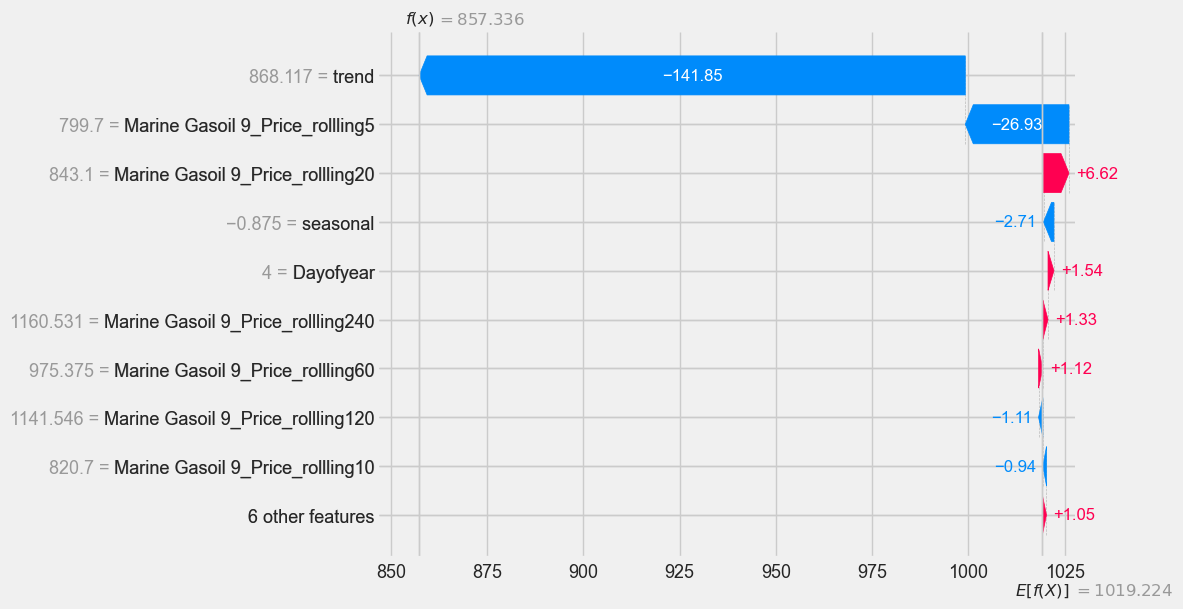

In [38]:
shap.initjs()
shap.waterfall_plot(shap.Explanation(values=shap_values_xgb[0],
                                     base_values=xgb_explainer.expected_value,
                                     data=X_train.iloc[0],
                                     feature_names=X_train.columns.tolist()))

In [39]:
# 실험 1. val 기간 늘리기
# 실험 2. trend 컬럼 제외
# 실험 3. seasonal 컬럼 제외
# 실험 4. 